In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
# Step 2: Enable interactive mode for Jupyter Notebook
%matplotlib inline
np.set_printoptions(formatter={'float_kind': lambda x: f"{x:0.6f}"})

# 1. Load, scale and display data

In [2]:
df = pd.read_excel('data2.xlsx')

In [3]:
df

,x1,x2,y,Notes
0,0.702637,0.926564,0.611205,Probably this is a peak #1
1,0.665800,0.123969,0.538996,Probably this is a peak #2
2,0.877791,0.778628,0.420586,NaN
3,0.845275,0.711120,0.293993,NaN
4,0.438166,0.685018,0.244619,NaN
...,...,...,...,...
69,0.695000,0.902174,0.645380,"The new, updated numbers on 14/07 for the same..."
70,0.768952,0.788966,0.115085,"The new, updated numbers on 14/07 for the same..."
71,0.692745,0.916637,0.621699,"The new, updated numbers on 14/07 for the same..."
72,0.678118,0.000000,0.607256,10/7 BO 1*std exp 0.697324


In [4]:
df = df.drop(columns=['Notes'])
df=df.dropna()

In [5]:
df

,x1,x2,y
0,0.702637,0.926564,0.611205
1,0.665800,0.123969,0.538996
2,0.877791,0.778628,0.420586
3,0.845275,0.711120,0.293993
4,0.438166,0.685018,0.244619
...,...,...,...
69,0.695000,0.902174,0.645380
70,0.768952,0.788966,0.115085
71,0.692745,0.916637,0.621699
72,0.678118,0.000000,0.607256


# 2. Visualise data on plots

In [6]:
# two highest points in top_2_indices will have color in red
top_2_indices = df['y'].nlargest(2).index
top_qntl_index = df['y'].nlargest(int(df.shape[0]/3.0)).index
colors = np.full(df.shape[0], 'b', dtype=object)  # Default color is blue
colors[top_qntl_index] = 'y' # display the top qualtize as yellow
colors[top_2_indices] = 'r'  # Color top points red
df.iloc[top_2_indices]

,x1,x2,y
33,0.697055,0.903762,0.665976
58,0.700679,0.000000,0.655161


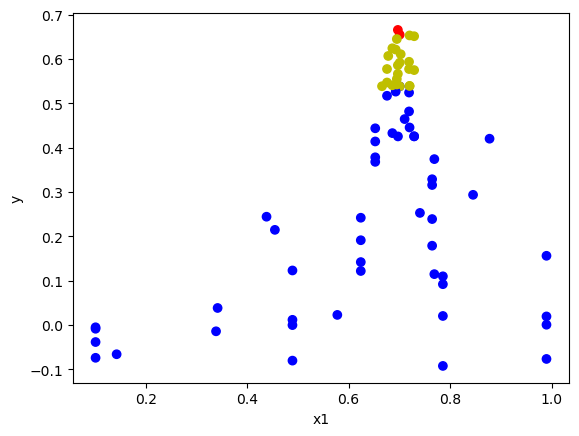

In [7]:
plt.scatter(df['x1'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x1')
plt.show()

Text(0.5, 0, 'x2')

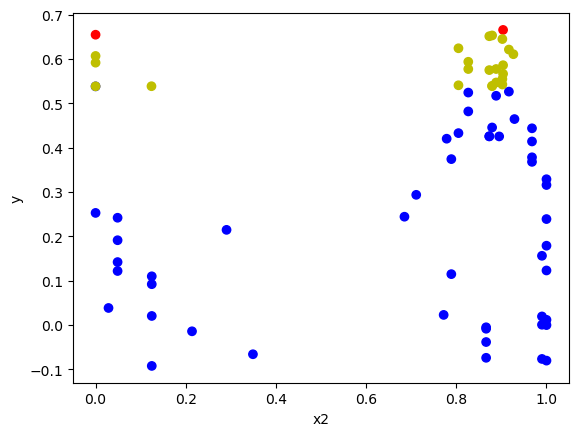

In [8]:
plt.scatter(df['x2'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x2')

# You can rotate 2 dimentional values

<IPython.core.display.Javascript object>


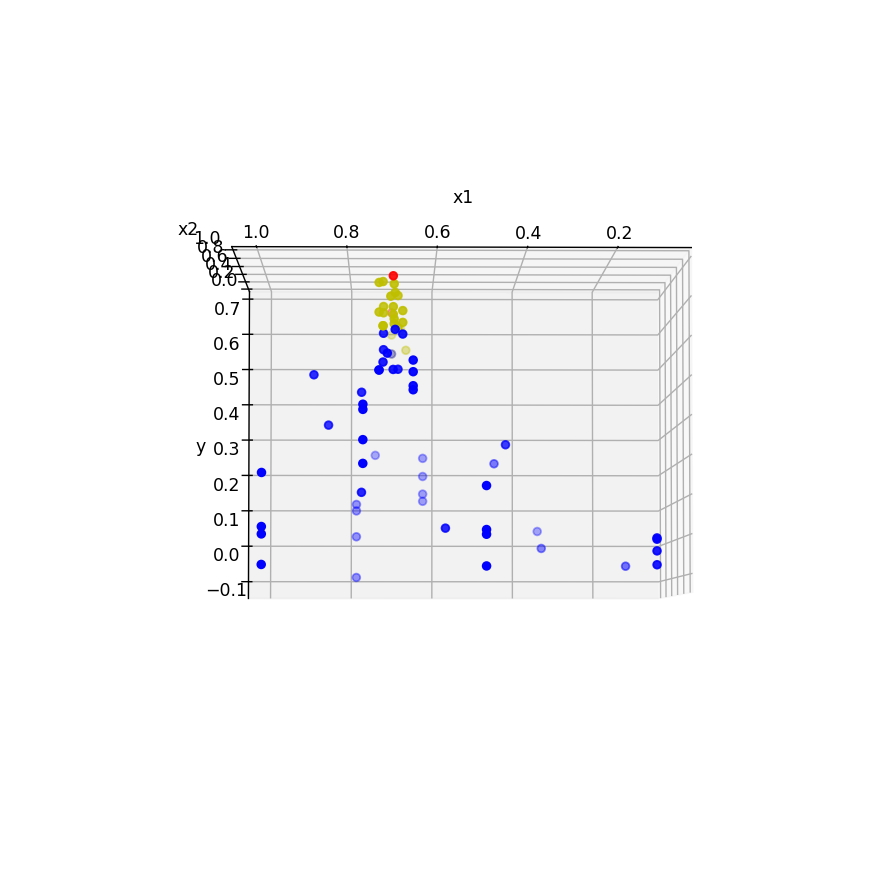

In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
ax.scatter(df['x1'], df['x2'], df['y'], c = colors)
# Set labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
# Display the plot
plt.show()

In [10]:
# do not forget to switch the previous grid off (: otherwise you can get error with s...
%matplotlib inline

# 3. Build the grid for Optimization
fine tune the size of grid for high dimention!

In [11]:
x = np.linspace(0,1,101).reshape(-1,1)

In [12]:
x_grid = np.array([[x1, x2] for x1 in x for x2 in x])
x_grid = x_grid.squeeze()

In [13]:
# Prepare X and y for optimization tools
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy().reshape(-1,1)

# 4. Use Gaussian Process Regressor with Radial Based Function and WhiteKernel (because of noise)

In [14]:
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-2, 1e7)) + \
    WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-10, 1e1))
bo_model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=1000, normalize_y=True)

In [15]:
bo_model.fit(X, y)

GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * RBF(length_scale=0.2) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=1000, normalize_y=True)

In [16]:
# Check that predicted values are equal originals - this is just a control point
np.column_stack( (y,bo_model.predict(X)) )

array([[0.611205, 0.547546],
       [0.538996, 0.510047],
       [0.420586, 0.407894],
       [0.293993, 0.299585],
       [0.244619, 0.253345],
       [0.214965, 0.225942],
       [0.038749, 0.067940],
       [0.023106, 0.055157],
       [-0.013858, 0.020252],
       [-0.065624, -0.026075],
       [0.000955, 0.033473],
       [-0.004808, -0.021405],
       [0.239331, 0.267897],
       [0.092398, 0.041111],
       [0.123360, 0.022423],
       [0.368356, 0.403661],
       [0.191571, 0.184241],
       [0.592092, 0.565808],
       [0.577746, 0.537113],
       [0.425937, 0.520924],
       [0.539490, 0.540709],
       [0.019675, 0.033473],
       [-0.073652, -0.021405],
       [0.179204, 0.267897],
       [0.110197, 0.041111],
       [0.012033, 0.022423],
       [0.378645, 0.403661],
       [0.122187, 0.184241],
       [0.538658, 0.565808],
       [0.524664, 0.537113],
       [0.425937, 0.520924],
       [0.539490, 0.540709],
       [0.517411, 0.547494],
       [0.665976, 0.570621],
       

In [17]:
bo_model.kernel_

0.953**2 * RBF(length_scale=0.0521) + WhiteKernel(noise_level=0.0994)

In [18]:
# Predict for the grid
post_mean, post_std = bo_model.predict(x_grid, return_std=True)

In [19]:
# Define acquiring function
a_fun = post_mean + 1 * post_std

In [20]:
# Find the index and maximum value of aquiring function
i = np.argmax(a_fun)
print('The maximum of acquiring function is', a_fun[i],'the max index is',i)
print('post_mean =', post_mean[i],' post_std =', post_std[i])
print('the next point for Bayesian Optimization is',x_grid[i])

The maximum of acquiring function is 0.6906335581803758 the max index is 6868
post_mean = 0.5985994368241097  post_std = 0.0920341213562661
the next point for Bayesian Optimization is [0.680000 0.000000]


In [21]:
# I would like to find out the points even better than grid
# I use optimize.minimize function over bayesian predictor
# This piece of code is useful for multi-dimentionsfrom scipy.optimize import minimize
def aquisition_fun(x):
    x = np.atleast_2d(x)
    post_mean, post_std = bo_model.predict(x, return_std=True)
    return -(post_mean + 1 * post_std)
result = minimize(aquisition_fun, x_grid[i], bounds=[(0, 0.999999)]*2, tol=1e-8)
optimal_point = result.x
optimal_value = -result.fun
print(f"Optimal value {optimal_value:0.6f}")
print("at point", optimal_point)

Optimal value 0.690643
at point [0.680313 0.000000]


# Use Second attempt for Gaussian Process Regressor with Radial Based Function and WhiteKernel to predict the second maximum

In [22]:
second_point = X[33] #<- I just grab it from graphical data analysis

In [23]:
from scipy.optimize import minimize
def aquisition_fun(x):
    x = np.atleast_2d(x)
    post_mean, post_std = bo_model.predict(x, return_std=True)
    return -(post_mean + 1 * post_std)
result = minimize(aquisition_fun, second_point, bounds=[(0, 0.999999)]*2, tol=1e-8)
optimal_point = result.x
optimal_value = -result.fun
print(f"Optimal value {optimal_value:0.6f}")
print("at point", optimal_point)

Optimal value 0.652453
at point [0.687288 0.911523]
